# Models and Evaluation

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

data = pd.read_csv('data_processed/complete/data_selected.csv')

display(data.head())

,loan_id,loan_amount,loan_payments,has_disponent,mean_balance,min_balance,negative_balance,monthly_diff,a_freq_monthly_issuance,a_freq_weekly_issuance,status
0,5314,96396,8033,False,12250.000000,1100.0,0.0,6700,0.0,1.0,-1
1,5316,165960,4610,False,52083.859459,700.0,0.0,14733,1.0,0.0,1
2,6863,127080,2118,False,30060.954167,800.0,0.0,-6859,1.0,0.0,1
3,5325,105804,2939,False,41297.480000,1000.0,0.0,-11054,1.0,0.0,1
4,7240,274740,4579,False,57188.211111,600.0,0.0,-30531,0.0,1.0,1


In [2]:
def get_features(df):
    return df.drop('status', axis=1)
def get_target(df):
    return df.drop(df.columns.difference(['status']), axis=1)

results = {}

### Split data

In [3]:
def split_data(features, target, test_size=0.25, random_state=1):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [4]:
print('Data shape:',data.shape)
print('Status  1:',data[data['status']==1].shape)
print('Status -1:',data[data['status']==-1].shape)

_X_train, _X_test, _y_train, _y_test = split_data(get_features(data), get_target(data))

print('\nTrain shape:',_y_train.shape)
print('Status ratio:',_y_train[_y_train['status']==1].shape[0],'|',_y_train[_y_train['status']==-1].shape[0])

print('\nTest shape:',_y_test.shape)
print('Status ration:',_y_test[_y_test['status']==1].shape[0],'|',_y_test[_y_test['status']==-1].shape[0])

Data shape: (328, 11)
Status  1: (282, 11)
Status -1: (46, 11)

Train shape: (246, 1)
Status ratio: 210 | 36

Test shape: (82, 1)
Status ration: 72 | 10


### Resampling

In [5]:
def oversample(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=1, sampling_strategy=1.0)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

In [6]:
_smote_X_train, _smote_y_train = oversample(_X_train, _y_train)

print('\nTrain shape:',_smote_y_train.shape)
print('Status ratio:',_smote_y_train[_smote_y_train['status']==1].shape[0],'|',_smote_y_train[_smote_y_train['status']==-1].shape[0])


Train shape: (420, 1)
Status ratio: 210 | 210


### Scaling

In [7]:
def normalize_data(X_train, X_test, scaler):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    return X_train, X_test

def standardize_data(X_train, X_test):
    from sklearn.preprocessing import StandardScaler
    return normalize_data(X_train, X_test, StandardScaler())
def min_max_scaling(X_train, X_test):
    from sklearn.preprocessing import MinMaxScaler
    return normalize_data(X_train, X_test, MinMaxScaler())

### Algorithms

In [8]:
def add_model(name, model, use_smote=False, scale=False):
    import datetime
    X_train = _X_train.copy() if not use_smote else _smote_X_train.copy()
    y_train = _y_train.copy() if not use_smote else _smote_y_train.copy()
    X_test = _X_test.copy()

    # Scaling Normalizations
    if scale == 'standard':
        X_train, X_test = standardize_data(X_train, X_test)
    elif scale == 'min_max':
        X_train, X_test = min_max_scaling(X_train, X_test)
    

    start = datetime.datetime.now()
    model.fit(X_train, np.ravel(y_train.values))
    end = datetime.datetime.now()
    
    results[name] = {'model': model, 
                    'X_train': X_train, 
                    'X_test': X_test, 
                    'y_train': np.ravel(y_train.values), 
                    'y_test': np.ravel(_y_test.values),
                    'fit_time': (end - start).microseconds / 1000 # time difference in milliseconds
                    }

In [9]:
SMOTE = True

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
add_model('dtc',
    DecisionTreeClassifier(max_depth=5),
    use_smote=SMOTE
)


In [11]:
from sklearn.neighbors import KNeighborsClassifier
add_model('knn',
    KNeighborsClassifier(),
    use_smote=SMOTE
)

In [12]:
from sklearn.neural_network import MLPClassifier
add_model('mlp',
    MLPClassifier(),
    use_smote=SMOTE
)

In [13]:
from sklearn.naive_bayes import GaussianNB
add_model('gnb',
    GaussianNB(),
    use_smote=SMOTE
)

In [14]:
from sklearn.svm import SVC
add_model('svc',
    SVC(probability=True),
    use_smote=SMOTE,
    scale='standard'
)

In [15]:
from sklearn.linear_model import LogisticRegression
add_model('lr',
    LogisticRegression(),
    use_smote=SMOTE
)

In [16]:
from sklearn.ensemble import RandomForestClassifier
add_model('rf',
    RandomForestClassifier(),
    use_smote=SMOTE
)


In [17]:
from sklearn.ensemble import GradientBoostingClassifier
add_model('gb',
    GradientBoostingClassifier(),
    use_smote=SMOTE
)

### Feature Importance

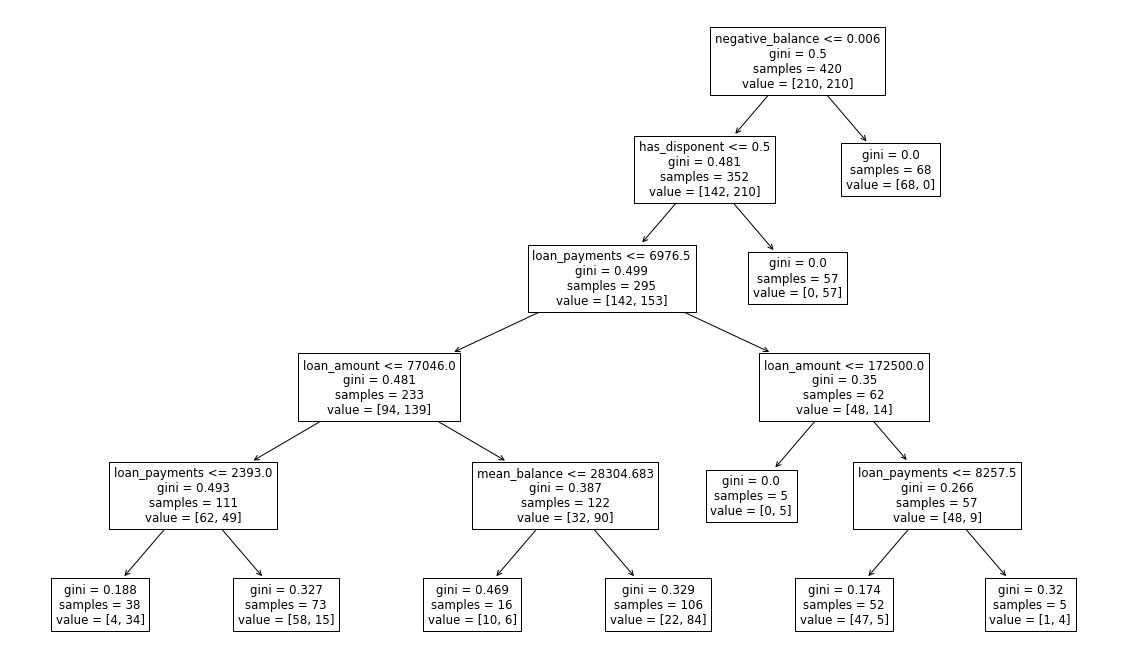

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20, 12])
plot_tree(results['dtc']['model'], feature_names=_X_train.columns)
plt.savefig('dtc.png')

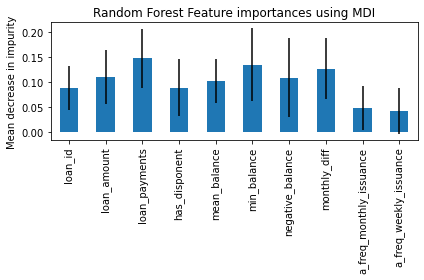

In [19]:
import matplotlib.pyplot as plt
importances = results['rf']['model'].feature_importances_
std = np.std([tree.feature_importances_ for tree in results['rf']['model'].estimators_], axis=0)
forest_importances = pd.Series(importances, index=_X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Random Forest Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Prediction

In [20]:
def predict(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    pred = result['model'].predict(result['X_'+prefix])
    result[prefix+'pred'] = pred

for name in results.keys():
    predict(name)
for name in results.keys():
    predict(name, isTrain=True)

In [21]:
def predict_proba(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    proba = result['model'].predict_proba(result['X_'+prefix])
    result[prefix+'pred_prob'] = proba

for name in results.keys():
    predict_proba(name)
for name in results.keys():
    predict_proba(name, isTrain=True)


## Evaluation

In [22]:
from matplotlib.figure import Figure
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def conf_matrix(y_test, y_pred, name, prefix):
    cm =  confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['True', 'False'])
    disp.plot()
    disp.ax_.set_title(name + ' ' + prefix)

### Execution time

In [23]:
def fit_time(name):
    result = results[name]
    print(name.upper()+':\t', result['fit_time'], 'ms')

print('Fit execution time')
for name in results.keys():
    fit_time(name)

Fit execution time
DTC:	 2.301 ms
KNN:	 1.757 ms
MLP:	 432.748 ms
GNB:	 1.491 ms
SVC:	 22.994 ms
LR:	 8.028 ms
RF:	 129.381 ms
GB:	 86.586 ms


### Accuracy

In [24]:
def score(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    result[prefix+'score'] = result['model'].score(result['X_'+prefix], result['y_'+prefix])
    print(name.upper()+":\t", result[prefix+'score'])

print('\tAccuracy')
print("Test")
for name in results.keys():
    score(name)
print("\nTrain")
for name in results.keys():
    score(name, isTrain=True)

	Accuracy
Test
DTC:	 0.8658536585365854
KNN:	 0.7560975609756098
MLP:	 0.6097560975609756
GNB:	 0.5121951219512195
SVC:	 0.7804878048780488
LR:	 0.7682926829268293
RF:	 0.9512195121951219
GB:	 0.9512195121951219

Train
DTC:	 0.8738095238095238
KNN:	 0.8761904761904762
MLP:	 0.7214285714285714
GNB:	 0.65
SVC:	 0.8857142857142857
LR:	 0.7095238095238096
RF:	 1.0
GB:	 0.9952380952380953


### Precision, Recall and F-measure

In [25]:
from sklearn.metrics import f1_score, precision_score, recall_score


def evaluate(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    precision = precision_score(result['y_'+prefix], result[prefix+'pred'], pos_label=-1)
    recall = recall_score(result['y_'+prefix], result[prefix+'pred'], pos_label=-1)
    f_measure = f1_score(result['y_'+prefix], result[prefix+'pred'], pos_label=-1)
    print(prefix, name.upper()+":", '\tRecall:',round(recall, 2), '\t Precision:',round(precision, 2), '\tF_Measure:',round(f_measure, 2))

print('Test')
for name in results.keys():
    evaluate(name)
print('\nTrain')
for name in results.keys():
    evaluate(name, isTrain=True)


Test
test DTC: 	Recall: 0.8 	 Precision: 0.47 	F_Measure: 0.59
test KNN: 	Recall: 0.4 	 Precision: 0.22 	F_Measure: 0.29
test MLP: 	Recall: 0.8 	 Precision: 0.21 	F_Measure: 0.33
test GNB: 	Recall: 0.5 	 Precision: 0.12 	F_Measure: 0.2
test SVC: 	Recall: 0.7 	 Precision: 0.32 	F_Measure: 0.44
test LR: 	Recall: 0.8 	 Precision: 0.32 	F_Measure: 0.46
test RF: 	Recall: 0.8 	 Precision: 0.8 	F_Measure: 0.8
test GB: 	Recall: 0.7 	 Precision: 0.88 	F_Measure: 0.78

Train
train DTC: 	Recall: 0.87 	 Precision: 0.88 	F_Measure: 0.87
train KNN: 	Recall: 0.95 	 Precision: 0.83 	F_Measure: 0.88
train MLP: 	Recall: 0.9 	 Precision: 0.66 	F_Measure: 0.76
train GNB: 	Recall: 0.83 	 Precision: 0.61 	F_Measure: 0.7
train SVC: 	Recall: 0.9 	 Precision: 0.88 	F_Measure: 0.89
train LR: 	Recall: 0.67 	 Precision: 0.73 	F_Measure: 0.7
train RF: 	Recall: 1.0 	 Precision: 1.0 	F_Measure: 1.0
train GB: 	Recall: 0.99 	 Precision: 1.0 	F_Measure: 1.0


### Confusion Matrix

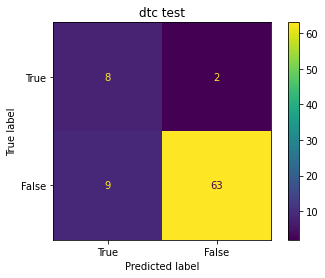

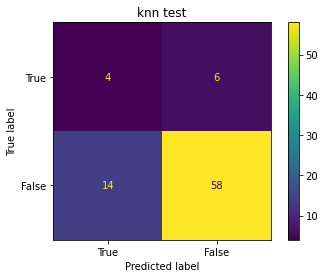

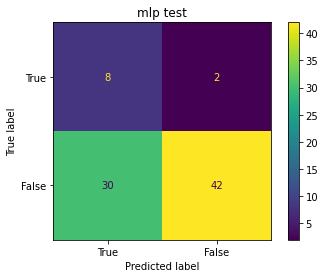

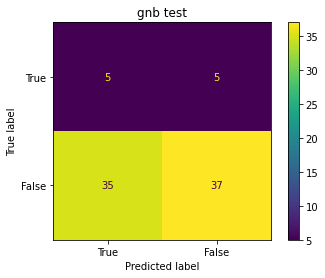

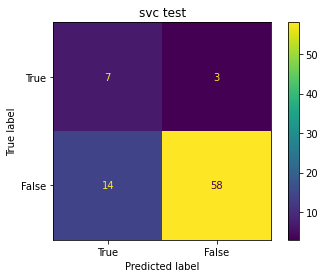

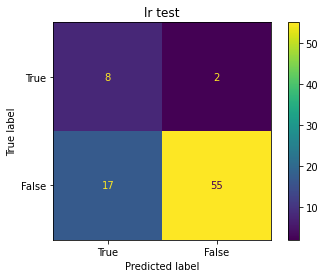

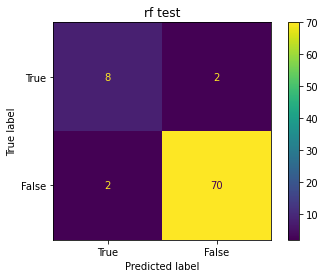

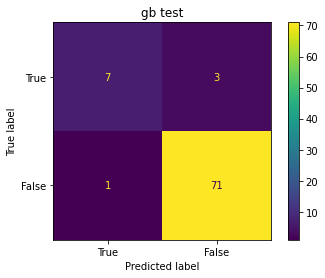

In [26]:
prob = 0.50

prefixes = ('test', 'train')
for prefix in prefixes[:1]:
    for name in results.keys():
        result = results[name]
        prefix = 'test'
        conf_matrix(result['y_'+prefix], np.where(result[prefix+'pred_prob'][:,-1] > prob, 1, -1), name, prefix)

### AUC

DTC test:	 0.8618055555555555
DTC train:	 0.9273356009070295
KNN test:	 0.7777777777777778
KNN train:	 0.9649659863945579
MLP test:	 0.7791666666666666
MLP train:	 0.7374489795918366
GNB test:	 0.5444444444444445
GNB train:	 0.7366439909297053
SVC test:	 0.8291666666666666
SVC train:	 0.9572789115646259
LR test:	 0.8916666666666667
LR train:	 0.7759183673469388
RF test:	 0.973611111111111
RF train:	 1.0
GB test:	 0.9249999999999999
GB train:	 0.9998866213151927


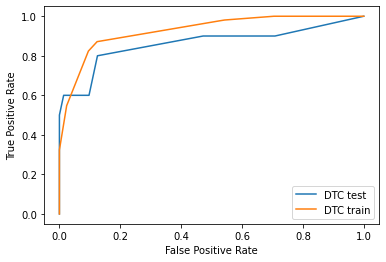

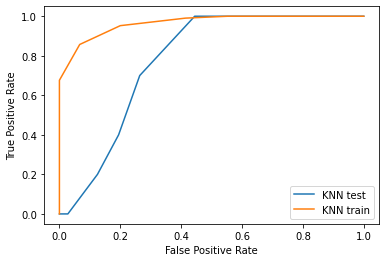

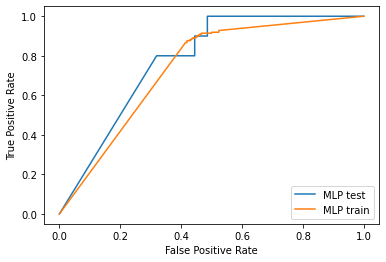

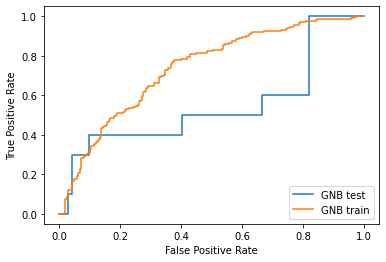

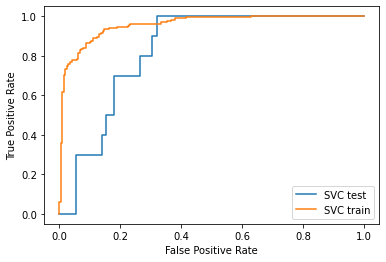

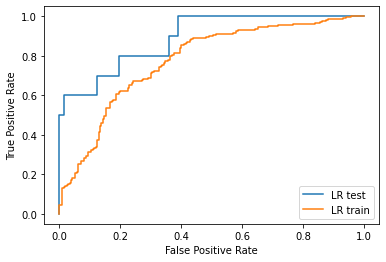

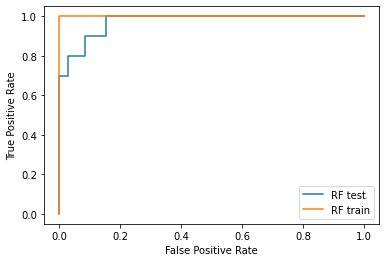

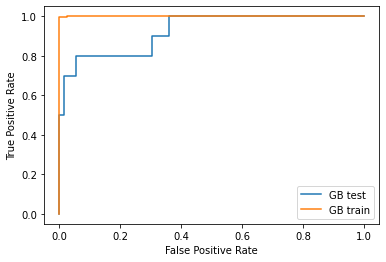

In [27]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
import matplotlib.pyplot as plt

def roc_and_auc(name, isTrain=False):
    fig, ax = plt.subplots()
    for prefix in ('test', 'train'):
        result = results[name]
        fpr, tpr, thresholds = roc_curve(result['y_'+prefix], result[prefix+'pred_prob'][:,0], pos_label=result['model'].classes_[0])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax,name=(name.upper()+' '+prefix))
        print(name.upper(), prefix + ":\t", auc(fpr, tpr))

for name in results.keys():
    roc_and_auc(name)